# Necessary Imports
---

In [18]:
import os
import cv2
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

# Loading Dataset
---

In [23]:
root = '.'
# train_dataset_loc = root + '/fashion-mnist_train.csv'
test_dataset_loc = root + '/test_dataset_b2.csv'

# df_train = pd.read_csv(train_dataset_loc)
df_test = pd.read_csv(test_dataset_loc)

# Converting data to images :)

In [25]:
viewtest = (df_test + 1) * 127.5
for i in range(4):
    img = np.array(viewtest.iloc[i][:-1])
    img = img.reshape(28, 28)
    cv2.imwrite(f'image-{i+1}.jpg', img)

# Pre-processing
---

In [6]:
def scale_data(df):
    pixel_columns = df.columns[1:]  # Excludes the 'label' column
    df[pixel_columns] = df[pixel_columns] / 255.0

# Comment: Maynot be necessary, Done in the BatchNormalization Part

# Start
---

## Adam Optimizer

In [3]:
class AdamOptimizer:
    def __init__(self, learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        """ beta1: Exponential decay rate for the first moment estimates
            beta2: Exponential decay rate for the second moment estimates """
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon # Noise addition to avoid division by zero
        self.m = {}
        self.v = {}
        self.iterations = 0

    def update(self, params, grads, layer_id):
        self.iterations += 1
        updated_params = {}
        for key in params.keys():
            """
            Different optimization momentum and decaying learning rate for each layer.
            So, unique key based moment and velocity dictionary is maintained for each layer.
            """
            unique_key = f"{layer_id}_{key}"
            if unique_key not in self.m:
                self.m[unique_key] = np.zeros_like(grads[key])
                self.v[unique_key] = np.zeros_like(grads[key])
            
            # Moment Update
            self.m[unique_key] = self.beta1 * self.m[unique_key] + (1 - self.beta1) * grads[key]
            # Velocity Update
            self.v[unique_key] = self.beta2 * self.v[unique_key] + (1 - self.beta2) * (grads[key] ** 2)
            
            """
            Bias Correction: The first few iterations, the moment and velocity estimates are biased towards zero (init).
            """
            m_corrected = self.m[unique_key] / (1 - self.beta1 ** self.iterations)
            v_corrected = self.v[unique_key] / (1 - self.beta2 ** self.iterations)
            
            updated_params[key] = params[key] - self.learning_rate * m_corrected / (np.sqrt(v_corrected) + self.epsilon)
        
        return updated_params


## Dense Layer
Every neuron is connected with each of the neuron in the next layer

In [4]:
class DenseLayer:
    def __init__(self, input_dim, output_dim):
        self.weights = np.random.randn(input_dim, output_dim) * 0.01
        self.biases = np.zeros((1, output_dim))
        
    def forward(self, X):
        self.input = X
        self.output = np.dot(X, self.weights) + self.biases
        return self.output

    def backward(self, d_out):
        self.d_weights = np.dot(self.input.T, d_out)
        self.d_biases = np.sum(d_out, axis=0, keepdims=True)
        d_input = np.dot(d_out, self.weights.T)
        return d_input

    def update_params(self, optimizer, layer_id):
        params = {'weights': self.weights, 'biases': self.biases}
        grads = {'weights': self.d_weights, 'biases': self.d_biases}
        updated_params = optimizer.update(params, grads, layer_id)
        self.weights = updated_params['weights']
        self.biases = updated_params['biases']


## Batch Normalization
Output = ReLUFunction(BN(Affine Transformation))
- Execution Sequence
1. Affine Transformation = W.X + b
2. BN = InputNormalization -> Scaling(Gamma) and Shifting(Beta)
3. Activation Function = ReLU

In [5]:
class BatchNormalization:
    """
    BN = gamma * (X - mean) / sqrt(variance + epsilon) + beta
    Output = gamma * BN + beta

    Credit: Ioffe and Szegedy Paper on Batch Normalization
    """
    def __init__(self, dim, momentum=0.9, epsilon=1e-5):
        self.gamma = np.ones((1, dim))
        self.beta = np.zeros((1, dim))
        self.momentum = momentum
        self.running_mean = np.zeros((1, dim))
        self.running_variance = np.ones((1, dim))
        self.epsilon = epsilon

    def forward(self, X, training=True):
        if training:
            self.mean = np.mean(X, axis=0)
            self.variance = np.var(X, axis=0)
            self.X_centered = X - self.mean
            self.stddev_inv = 1 / np.sqrt(self.variance + self.epsilon)
            self.X_norm = self.X_centered * self.stddev_inv
            self.output = self.gamma * self.X_norm + self.beta

            # Running mean and variance with momentum for each batch, used in the testing phase
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * self.mean
            self.running_variance = self.momentum * self.running_variance + (1 - self.momentum) * self.variance
        else:
            self.X_norm = (X - self.running_mean) / np.sqrt(self.running_variance + self.epsilon)
            self.output = self.gamma * self.X_norm + self.beta
        return self.output

    def backward(self, d_out):
        """
        Goal: Compute dL/dX where X = Original input to the layer
        X_norm = (X - mean) / sqrt(variance + epsilon)
        Output = gamma * X_norm + beta
        Chain Rule: dL/dX = dL/dX_norm * dX_norm/dX + dL/dmean * dmean/dX + dL/dvariance * dvariance/dX
        """
        N, D = d_out.shape
        dX_norm = d_out * self.gamma
        d_variance = np.sum(dX_norm * self.X_centered * -0.5 * self.stddev_inv**3, axis=0)
        d_mean = np.sum(dX_norm * -self.stddev_inv, axis=0) + d_variance * np.mean(-2 * self.X_centered, axis=0)
        d_input = dX_norm * self.stddev_inv + d_variance * 2 * self.X_centered / N + d_mean / N
        self.d_gamma = np.sum(d_out * self.X_norm, axis=0)
        self.d_beta = np.sum(d_out, axis=0)
        return d_input

    def update_params(self, optimizer, layer_id):
        params = {'gamma': self.gamma, 'beta': self.beta}
        grads = {'gamma': self.d_gamma, 'beta': self.d_beta}
        updated_params = optimizer.update(params, grads, layer_id)
        self.gamma = updated_params['gamma']
        self.beta = updated_params['beta']


## Activation Function

In [6]:
class ReLU:
    def forward(self, X):
        self.output = np.maximum(0, X)
        return self.output

    def backward(self, d_out):
        return d_out * (self.output > 0)


## Dropout

In [7]:
class Dropout:
    def __init__(self, rate):
        self.rate = rate

    def forward(self, X, training=True):
        if training:
            self.mask = np.random.rand(*X.shape) > self.rate
            self.output = X * self.mask / (1 - self.rate)
            """
                Dropout Scaling: During training, we drop out some neurons, so the remaining neurons have to do more work.
                Scale Factor: 1 / (1 - rate)
            """
        else:
            self.output = X
        return self.output

    def backward(self, d_out):
        return d_out * self.mask / (1 - self.rate)


## Softmax

In [8]:
class Softmax:
    def forward(self, X):
        exps = np.exp(X - np.max(X, axis=1, keepdims=True))
        self.output = exps / np.sum(exps, axis=1, keepdims=True)
        return self.output

    def backward(self, d_out):
        return d_out


## Final **Feed Forward Neural Network** with **Backpropagation**

In [9]:
class NeuralNetwork:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, X, training=True):
        """
            Test Phase Exclusions: Dropout
            Test Phase Behavior Change: BatchNormalization
        """
        for layer in self.layers:
            if isinstance(layer, Dropout) or isinstance(layer, BatchNormalization):
                X = layer.forward(X, training=training)
            else:
                X = layer.forward(X)
        return X

    def backward(self, d_out):
        for layer in reversed(self.layers):
            d_out = layer.backward(d_out)

    def compute_loss(self, y_pred, y_true):
        return -np.sum(y_true * np.log(y_pred + 1e-8)) / y_pred.shape[0]

    def compute_loss_grad(self, y_pred, y_true):
        return (y_pred - y_true) / y_pred.shape[0]
    
    def get_max_prob(self, y_pred):
        # Returns the maximum probability class (== col_no of a row) (Output Layer)
        # np.argmax returns index
        return np.argmax(y_pred, axis=1)
    
    def plot_metrics(self, train_loss, train_accuracy, val_f1):
        fig, axs = plt.subplots(1, 3, figsize=(20, 5))
        axs[0].plot(train_loss, label='Training Loss')
        axs[0].set_title('Training Loss vs Epochs')
        axs[0].set_xlabel('Epochs')
        axs[0].set_ylabel('Loss')
        axs[0].legend()

        axs[1].plot(train_accuracy, label='Training Accuracy')
        axs[1].set_title('Training Accuracy vs Epochs')
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Accuracy')
        axs[1].legend()

        axs[2].plot(val_f1, label='Validation Macro F1')
        axs[2].set_title('Validation Macro F1 vs Epochs')
        axs[2].set_xlabel('Epochs')
        axs[2].set_ylabel('Macro F1')
        axs[2].legend()

        plt.tight_layout()
        plt.show()
    
    def get_train_validation_data(self, df_train):
        df_train, df_val = train_test_split(df_train.copy(), test_size=0.2, random_state=42)
        X_train = df_train.drop(columns=['label']).values
        y_train = df_train['label'].values
        X_val = df_val.drop(columns=['label']).values
        y_val = df_val['label'].values
        return X_train, y_train, X_val, y_val

    def train(self, df_train, epochs, batch_size, learning_rate):
        X_train, y_train, X_val, y_val = self.get_train_validation_data(df_train)
        optimizer = AdamOptimizer(learning_rate=learning_rate)

        val_macro_f1_dataset = []
        metrics = []
        print(f"{'Epoch':<10}{'Train Loss':<15}{'Train Accuracy':<20}{'Validation Loss':<20}{'Validation Accuracy':<25}{'Validation Macro-F1':<25}")
        for epoch in range(epochs):
            train_losses = []
            train_accuracies = []
            for i in range(0, X_train.shape[0], batch_size):
                X_batch = X_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]

                y_batch_onehot = np.eye(10)[y_batch]

                y_pred = self.forward(X_batch, training=True)
                
                # Training accuracy
                train_accuracy = np.mean(self.get_max_prob(y_pred) == y_batch)
                train_accuracies.append(train_accuracy)

                loss = self.compute_loss(y_pred, y_batch_onehot)
                train_losses.append(loss)
                
                loss_grad = self.compute_loss_grad(y_pred, y_batch_onehot)
                
                self.backward(loss_grad)
                for layer_id, layer in enumerate(self.layers):
                    if hasattr(layer, 'update_params'):
                        layer.update_params(optimizer, layer_id)


            train_loss = np.mean(train_losses)
            train_accuracy = np.mean(train_accuracies)

            # Validation
            y_val_pred = self.forward(X_val, training=False)
            val_loss = self.compute_loss(y_val_pred, np.eye(10)[y_val])
            val_accuracy = np.mean(self.get_max_prob(y_val_pred) == y_val)
            val_macro_f1 = f1_score(y_val, self.get_max_prob(y_val_pred), average='macro')
            val_macro_f1_dataset.append(val_macro_f1)

            metric = [f"{epoch + 1} / {epochs}", train_loss, train_accuracy, val_loss, val_accuracy, val_macro_f1]
            metrics.append(metric)
            print(f"{metric[0]:<10}{metric[1]:<15.4f}{metric[2]:<20.4f}{metric[3]:<20.4f}{metric[4]:<25.4f}{metric[5]:<25.4f}")

        # Plots ---------------
        metrics_df = pd.DataFrame(metrics, columns=['Epoch', 'Train Loss', 'Train Accuracy', 'Validation Loss', 'Validation Accuracy', 'Validation Macro F1'])
        self.plot_metrics(metrics_df['Train Loss'], metrics_df['Train Accuracy'], metrics_df['Validation Macro F1'])

        return np.mean(val_macro_f1_dataset) # Required for choosing the best model

    def save_weights(self, filename):
        weights = {}
        for i, layer in enumerate(self.layers):
            if isinstance(layer, DenseLayer):
                weights[f'layer_{i}_weights'] = layer.weights
                weights[f'layer_{i}_biases'] = layer.biases
            elif isinstance(layer, BatchNormalization):
                weights[f'layer_{i}_gamma'] = layer.gamma
                weights[f'layer_{i}_beta'] = layer.beta
                weights[f'layer_{i}_running_mean'] = layer.running_mean
                weights[f'layer_{i}_running_var'] = layer.running_variance
        with open(filename, 'wb') as f:
            pickle.dump(weights, f)

    def load_weights(self, filename):
        with open(filename, 'rb') as f:
            weights = pickle.load(f)
        for i, layer in enumerate(self.layers):
            if isinstance(layer, DenseLayer):
                layer.weights = weights[f'layer_{i}_weights']
                layer.biases = weights[f'layer_{i}_biases']
            elif isinstance(layer, BatchNormalization):
                layer.gamma = weights[f'layer_{i}_gamma']
                layer.beta = weights[f'layer_{i}_beta']
                layer.running_mean = weights[f'layer_{i}_running_mean']
                layer.running_variance = weights[f'layer_{i}_running_var']

## Architectures

In [10]:
large_arch1 = {
        "layer1": [
                DenseLayer(784, 1024),
                BatchNormalization(1024),
                ReLU(),
                Dropout(0.5),
        ],
        "layer2": [
                DenseLayer(1024, 512),
                BatchNormalization(512),
                ReLU(),
                Dropout(0.5),
        ],
        "layer3": [
                DenseLayer(512, 256),
                BatchNormalization(256),
                ReLU(),
                Dropout(0.5),
        ],
        "layer4": [
                DenseLayer(256, 128),
                BatchNormalization(128),
                ReLU(),
                Dropout(0.5),
        ],
        "layer5": [
                DenseLayer(128, 10),
                Softmax(),
        ]
}


large_arch2 = {
        "layer1": [
                DenseLayer(784, 512),
                BatchNormalization(512),
                ReLU(),
                Dropout(0.5),
        ],
        "layer2": [
                DenseLayer(512, 256),
                BatchNormalization(256),
                ReLU(),
                Dropout(0.5),
        ],
        "layer3": [
                DenseLayer(256, 128),
                BatchNormalization(128),
                ReLU(),
                Dropout(0.5),
        ],
        "layer4": [
                DenseLayer(128, 64),
                BatchNormalization(64),
                ReLU(),
                Dropout(0.5),
        ],
        "layer5": [
                DenseLayer(64, 10),
                Softmax(),
        ]
}

small_arch = {
        "layer1": [
                DenseLayer(784, 128),
                BatchNormalization(128),
                ReLU(),
                Dropout(0.5),
        ],
        "layer2": [
                DenseLayer(128, 64),
                BatchNormalization(64),
                ReLU(),
                Dropout(0.5),
        ],
        "layer3": [
                DenseLayer(64, 10),
                Softmax(),
        ]
}


## Get Preferred Architecture

In [11]:
def getPreferredArchitecture(arch_type):
    if arch_type == 'large1':
        return large_arch1['layer1'] + large_arch1['layer2'] + large_arch1['layer3'] + large_arch1['layer4'] + large_arch1['layer5']
    elif arch_type == 'large2':
        return large_arch2['layer1'] + large_arch2['layer2'] + large_arch2['layer3'] + large_arch2['layer4'] + large_arch2['layer5']
    else:
        return small_arch['layer1'] + small_arch['layer2'] + small_arch['layer3']

architecture = 'small'
preferred_architecture = getPreferredArchitecture(architecture)

architectures = ['small', 'large1', 'large2']
learning_rates = [0.005, 0.004, 0.003, 0.001]

weights_dir = 'weights'
if not os.path.exists(weights_dir):
    os.makedirs(weights_dir)

# Model Training
---

Training "small" model with learning rate: 0.005
Epoch     Train Loss     Train Accuracy      Validation Loss     Validation Accuracy      Validation Macro-F1      
1 / 10    0.2958         0.8921              0.3628              0.8842                   0.8845                   
2 / 10    0.2839         0.8980              0.3580              0.8885                   0.8884                   
3 / 10    0.2760         0.8988              0.3643              0.8878                   0.8878                   
4 / 10    0.2661         0.9027              0.3617              0.8881                   0.8883                   
5 / 10    0.2637         0.9024              0.3594              0.8882                   0.8886                   
6 / 10    0.2660         0.9024              0.3625              0.8872                   0.8872                   
7 / 10    0.2603         0.9051              0.3618              0.8862                   0.8859                   
8 / 10    0.2607       

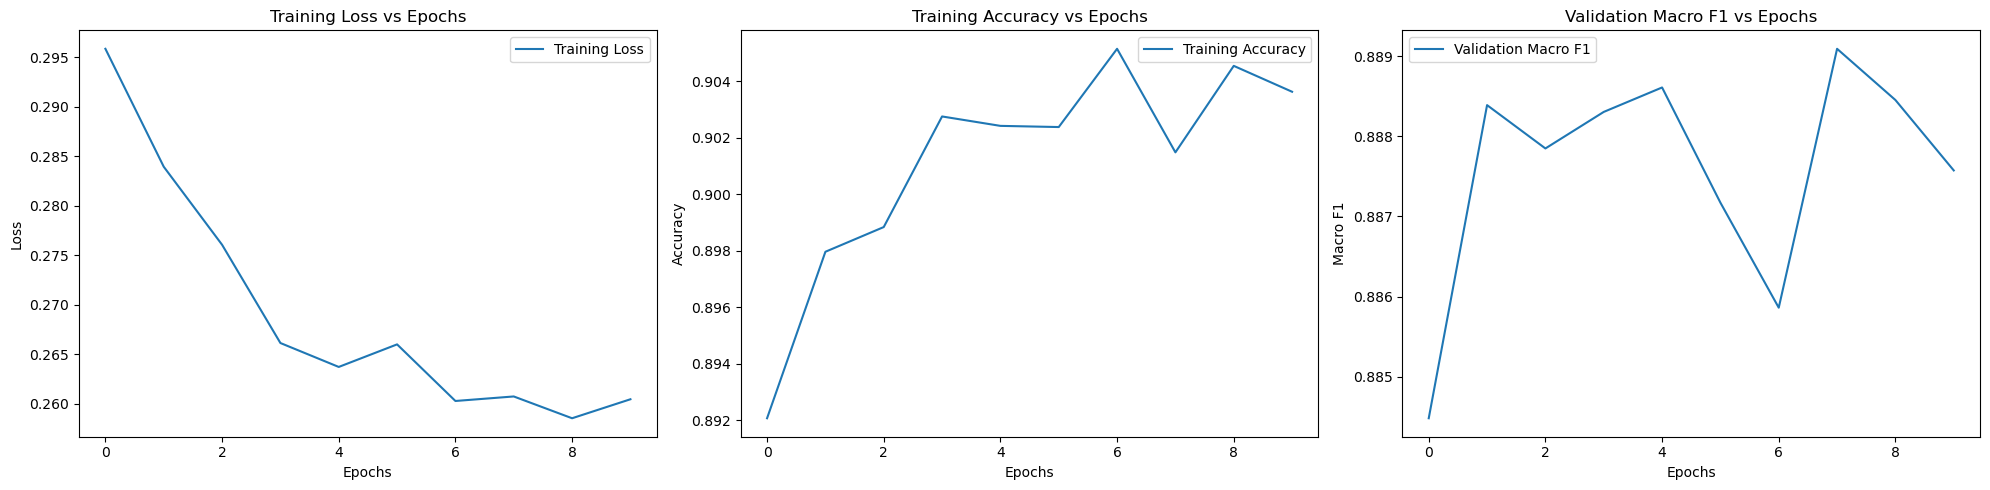

Training "small" model with learning rate: 0.004
Epoch     Train Loss     Train Accuracy      Validation Loss     Validation Accuracy      Validation Macro-F1      
1 / 10    0.2736         0.8987              0.3660              0.8841                   0.8842                   
2 / 10    0.2674         0.9026              0.3645              0.8905                   0.8909                   
3 / 10    0.2616         0.9054              0.3683              0.8896                   0.8900                   
4 / 10    0.2557         0.9069              0.3614              0.8889                   0.8899                   
5 / 10    0.2529         0.9072              0.3608              0.8899                   0.8907                   
6 / 10    0.2541         0.9085              0.3680              0.8895                   0.8895                   
7 / 10    0.2472         0.9091              0.3681              0.8874                   0.8882                   
8 / 10    0.2469       

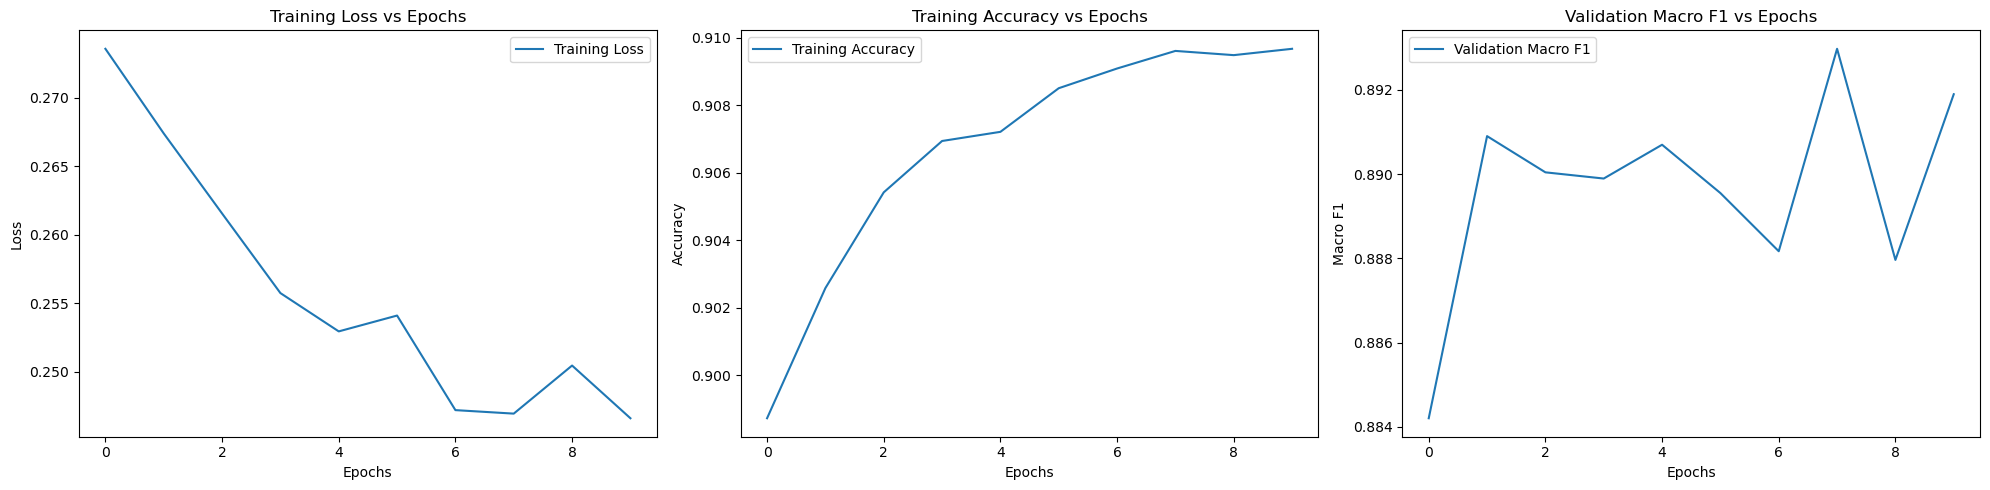

Training "small" model with learning rate: 0.003
Epoch     Train Loss     Train Accuracy      Validation Loss     Validation Accuracy      Validation Macro-F1      
1 / 10    0.2581         0.9073              0.3717              0.8881                   0.8885                   
2 / 10    0.2452         0.9116              0.3689              0.8895                   0.8900                   
3 / 10    0.2407         0.9107              0.3742              0.8882                   0.8886                   
4 / 10    0.2361         0.9140              0.3809              0.8897                   0.8903                   
5 / 10    0.2356         0.9142              0.3839              0.8881                   0.8889                   
6 / 10    0.2368         0.9138              0.3785              0.8871                   0.8880                   
7 / 10    0.2318         0.9137              0.3812              0.8894                   0.8904                   
8 / 10    0.2318       

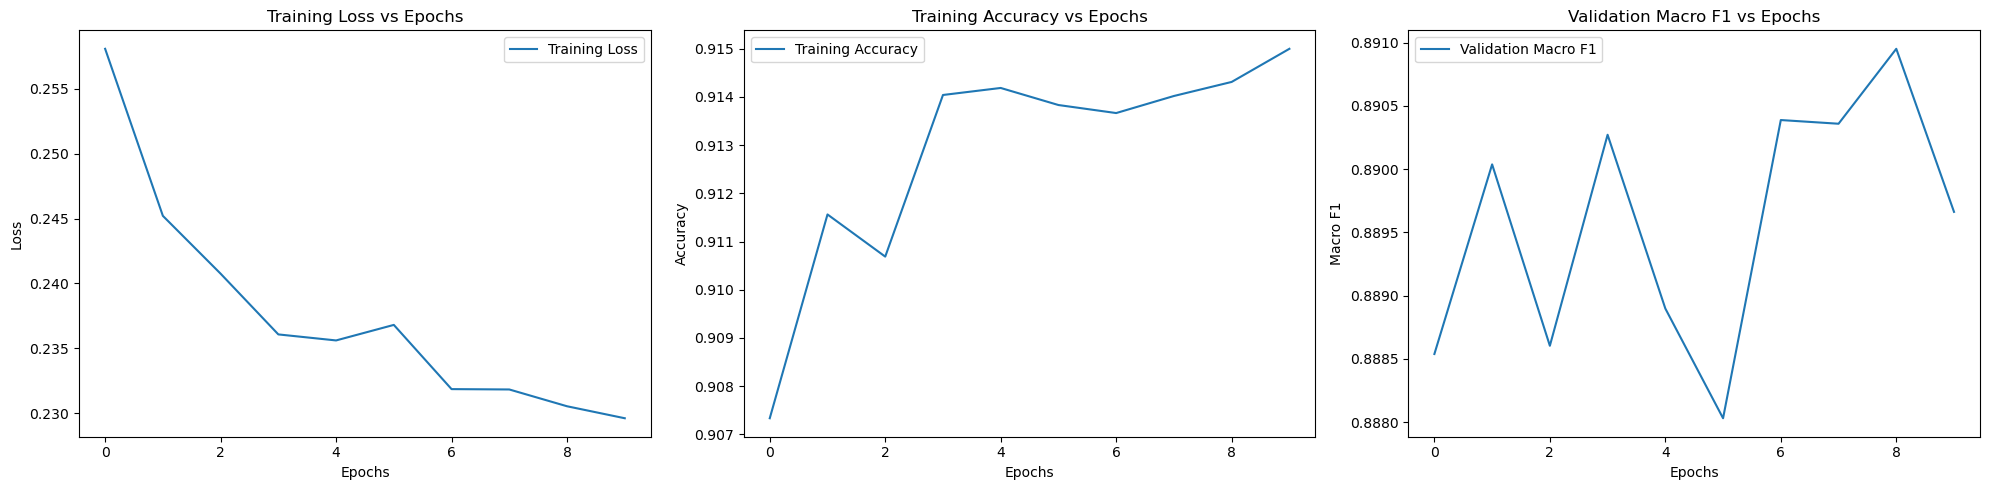

Training "small" model with learning rate: 0.001
Epoch     Train Loss     Train Accuracy      Validation Loss     Validation Accuracy      Validation Macro-F1      
1 / 10    0.2242         0.9184              0.3875              0.8912                   0.8920                   
2 / 10    0.2163         0.9210              0.3877              0.8903                   0.8913                   
3 / 10    0.2152         0.9212              0.3950              0.8894                   0.8903                   
4 / 10    0.2154         0.9204              0.3876              0.8893                   0.8902                   
5 / 10    0.2137         0.9218              0.3908              0.8901                   0.8912                   
6 / 10    0.2102         0.9228              0.3948              0.8884                   0.8893                   
7 / 10    0.2116         0.9215              0.3967              0.8896                   0.8905                   
8 / 10    0.2126       

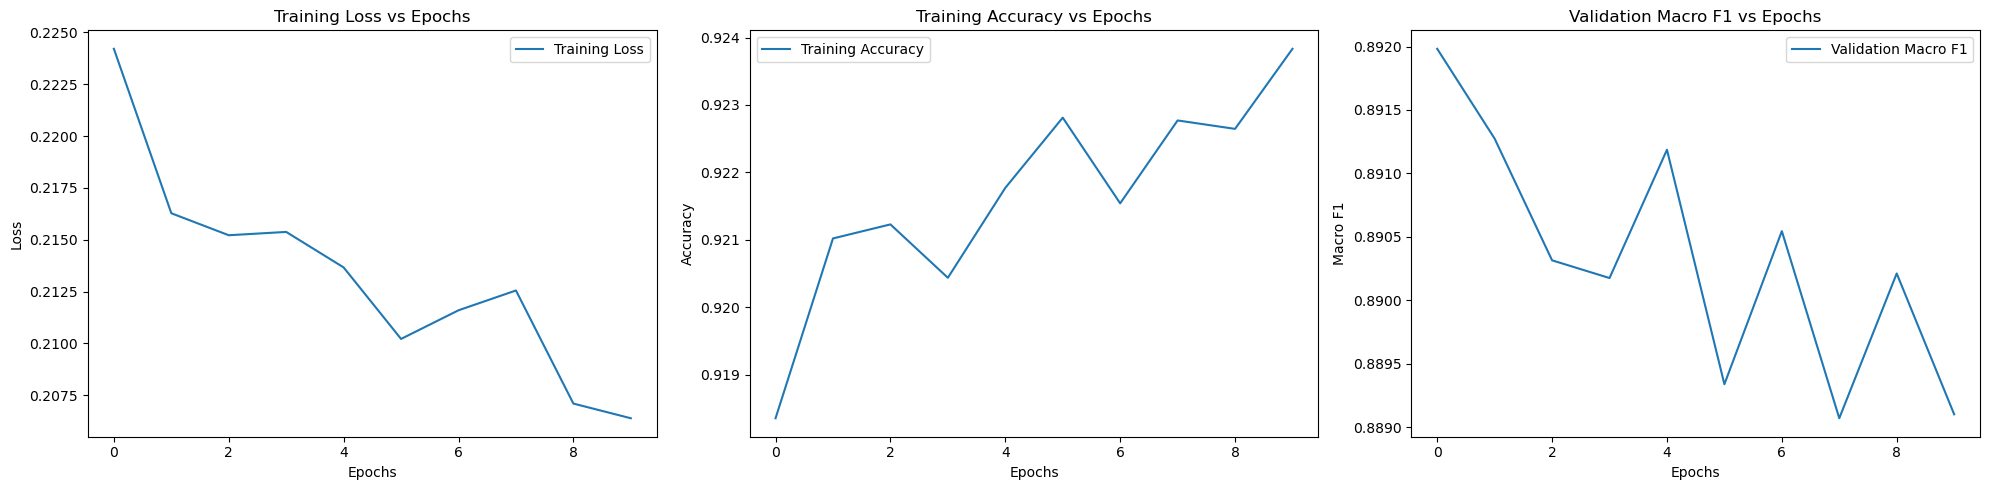

Training "large1" model with learning rate: 0.005
Epoch     Train Loss     Train Accuracy      Validation Loss     Validation Accuracy      Validation Macro-F1      
1 / 10    0.4126         0.8589              0.3200              0.8858                   0.8856                   
2 / 10    0.3631         0.8732              0.3126              0.8902                   0.8900                   
3 / 10    0.3409         0.8819              0.3119              0.8888                   0.8878                   
4 / 10    0.3241         0.8878              0.3051              0.8902                   0.8896                   
5 / 10    0.3133         0.8909              0.3028              0.8933                   0.8929                   
6 / 10    0.2982         0.8955              0.2993              0.8958                   0.8959                   
7 / 10    0.2969         0.8963              0.2955              0.8974                   0.8974                   
8 / 10    0.2858      

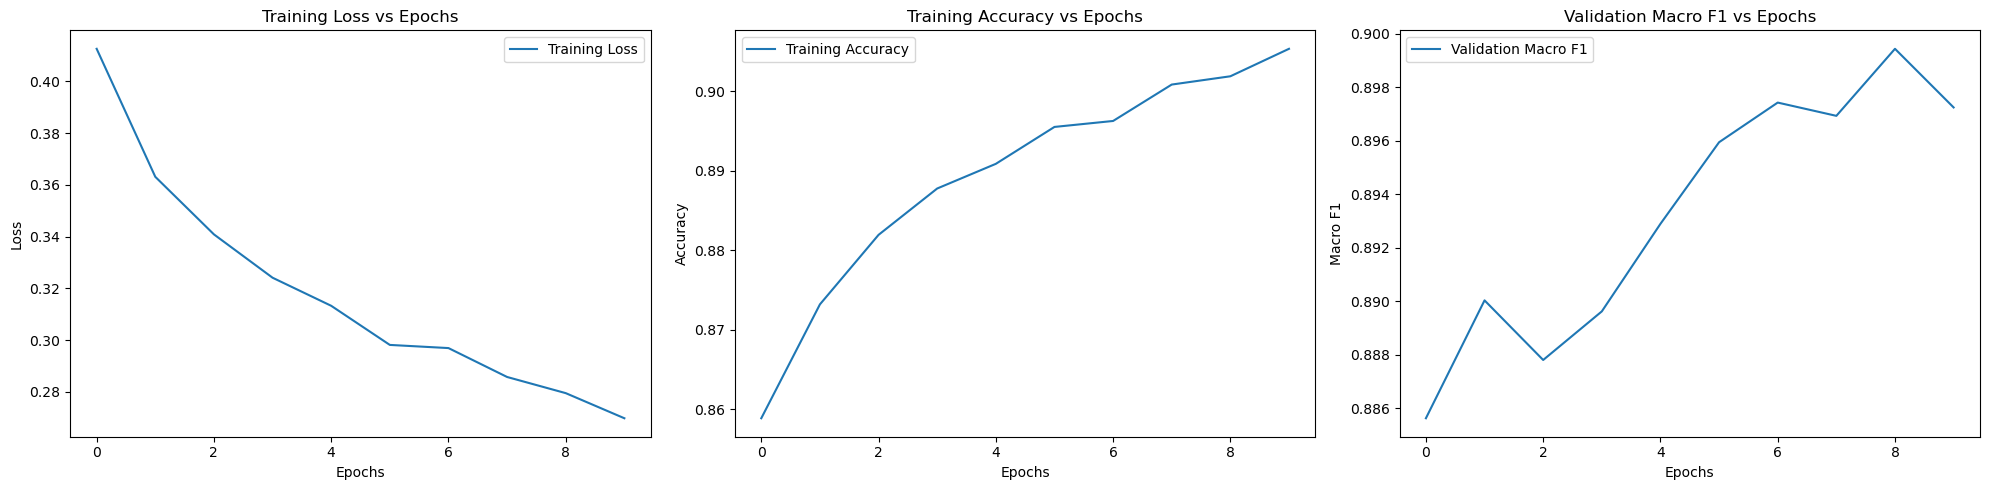

Training "large1" model with learning rate: 0.004
Epoch     Train Loss     Train Accuracy      Validation Loss     Validation Accuracy      Validation Macro-F1      
1 / 10    0.3041         0.8939              0.2993              0.8944                   0.8944                   
2 / 10    0.2743         0.9040              0.2991              0.8972                   0.8978                   
3 / 10    0.2523         0.9110              0.3008              0.8973                   0.8970                   
4 / 10    0.2433         0.9146              0.2952              0.9002                   0.9002                   
5 / 10    0.2353         0.9164              0.3049              0.8997                   0.8999                   
6 / 10    0.2265         0.9194              0.3046              0.8998                   0.9001                   
7 / 10    0.2234         0.9210              0.3022              0.9005                   0.9010                   
8 / 10    0.2195      

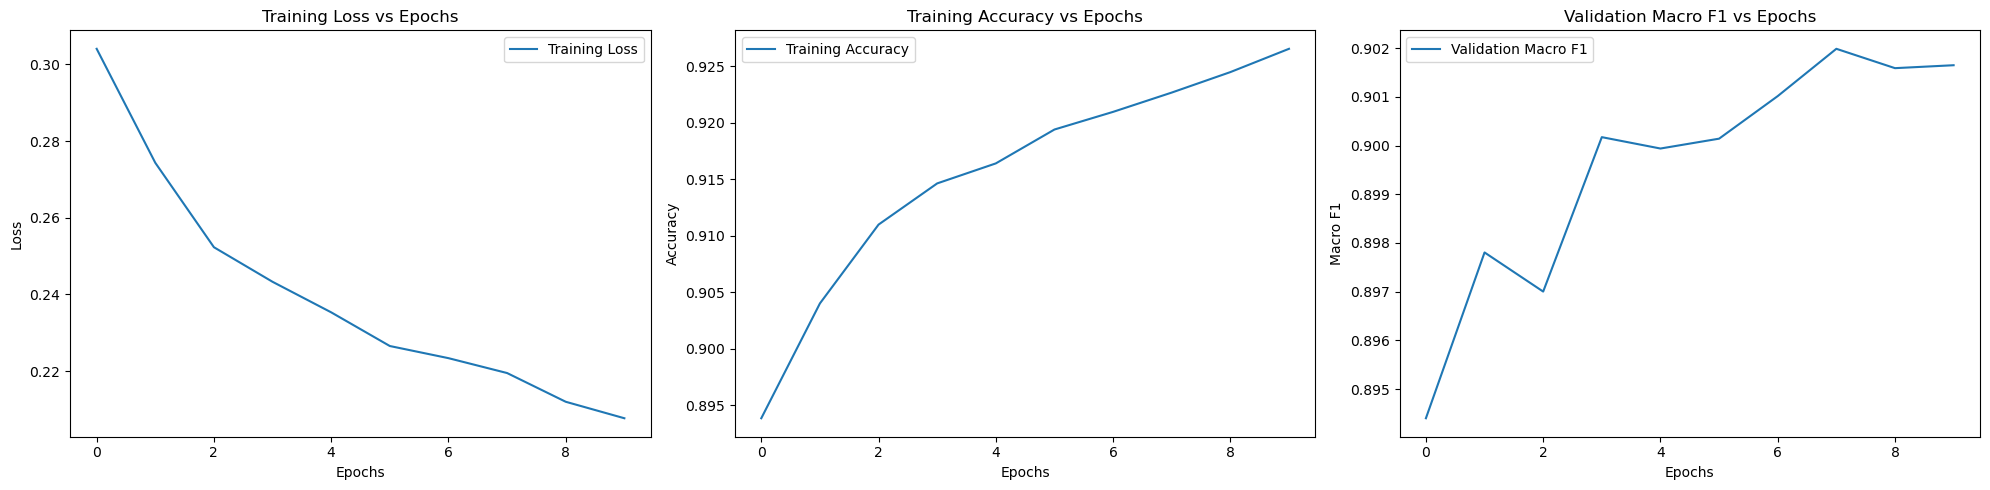

Training "large1" model with learning rate: 0.003
Epoch     Train Loss     Train Accuracy      Validation Loss     Validation Accuracy      Validation Macro-F1      
1 / 10    0.2279         0.9198              0.3096              0.9023                   0.9025                   
2 / 10    0.2046         0.9263              0.3105              0.9022                   0.9028                   
3 / 10    0.1967         0.9293              0.3196              0.9004                   0.9007                   
4 / 10    0.1849         0.9342              0.3247              0.9015                   0.9017                   
5 / 10    0.1794         0.9368              0.3154              0.9033                   0.9037                   
6 / 10    0.1739         0.9375              0.3219              0.9035                   0.9039                   
7 / 10    0.1689         0.9412              0.3302              0.9033                   0.9038                   
8 / 10    0.1676      

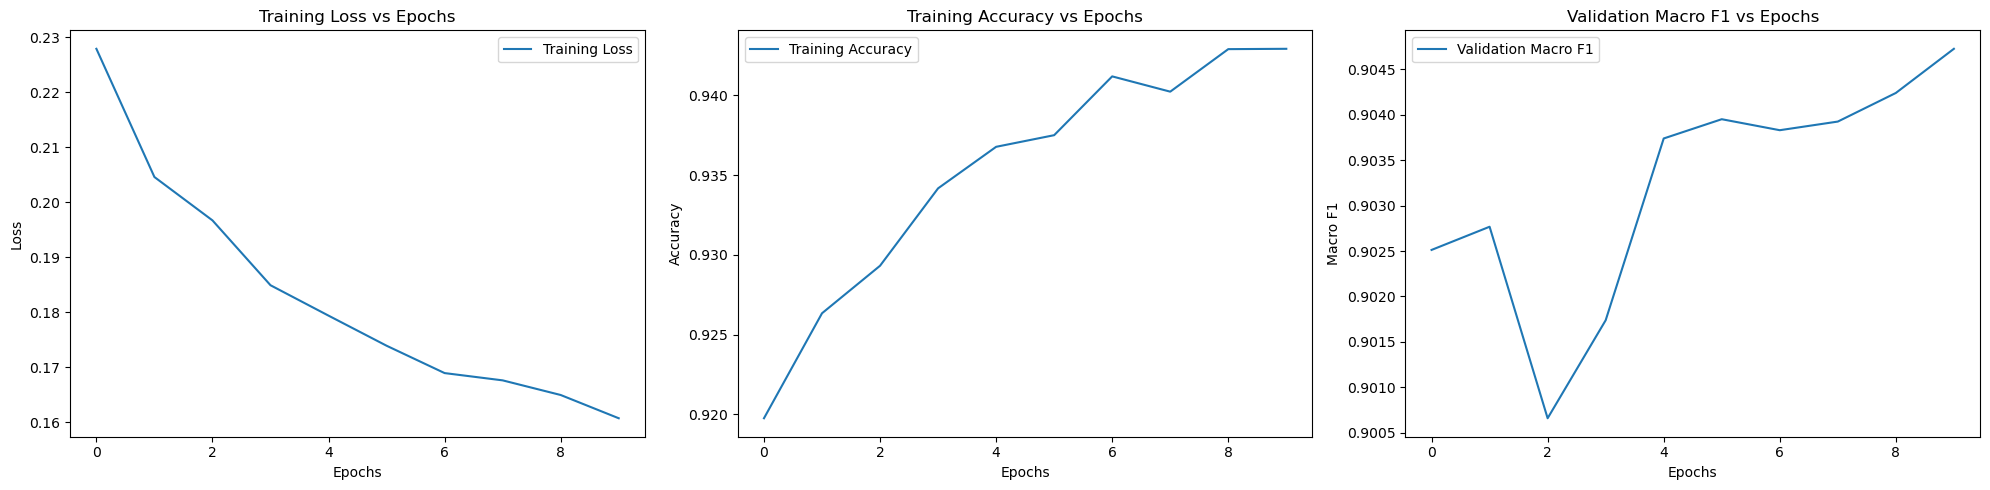

Training "large1" model with learning rate: 0.001
Epoch     Train Loss     Train Accuracy      Validation Loss     Validation Accuracy      Validation Macro-F1      
1 / 10    0.1500         0.9476              0.3324              0.9042                   0.9050                   
2 / 10    0.1364         0.9517              0.3397              0.9052                   0.9062                   
3 / 10    0.1308         0.9533              0.3458              0.9048                   0.9056                   
4 / 10    0.1241         0.9554              0.3491              0.9066                   0.9074                   
5 / 10    0.1221         0.9562              0.3506              0.9047                   0.9055                   
6 / 10    0.1177         0.9582              0.3585              0.9058                   0.9067                   
7 / 10    0.1157         0.9594              0.3563              0.9043                   0.9053                   
8 / 10    0.1147      

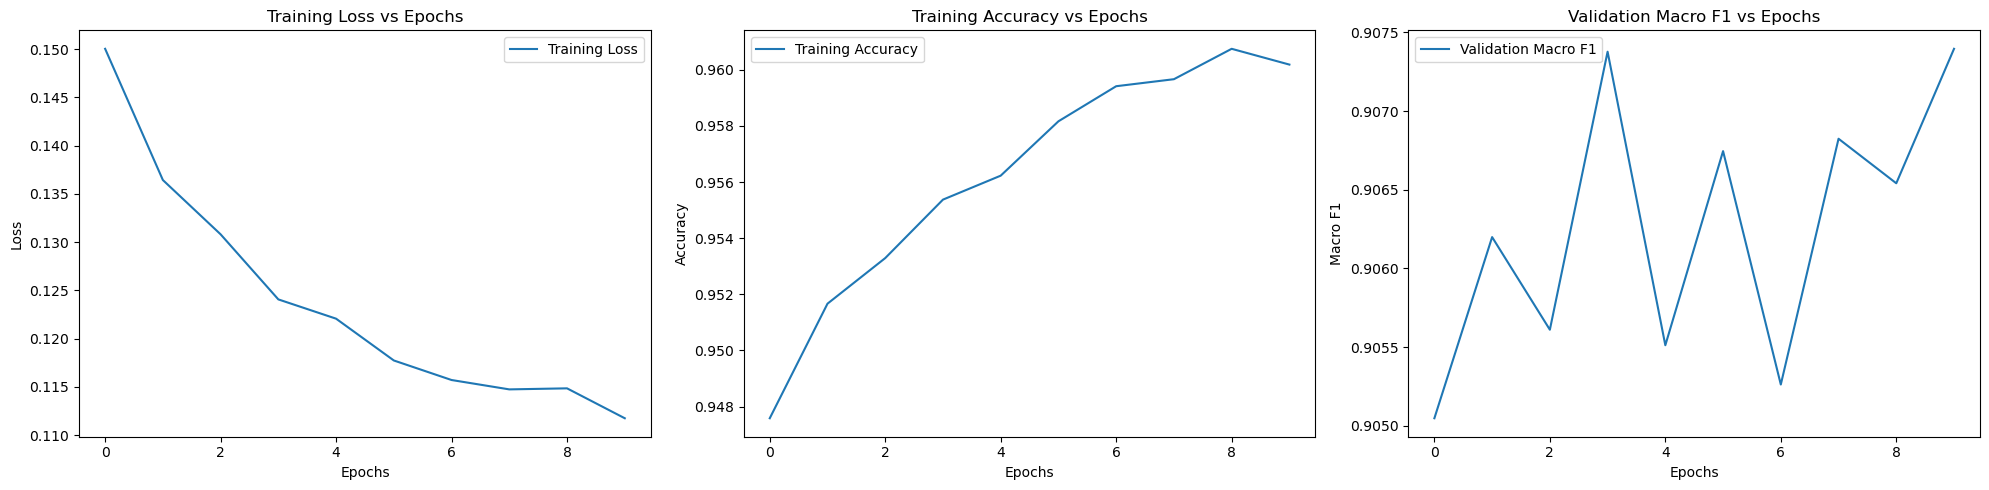

Training "large2" model with learning rate: 0.005
Epoch     Train Loss     Train Accuracy      Validation Loss     Validation Accuracy      Validation Macro-F1      
1 / 10    0.7823         0.7205              0.4832              0.8052                   0.7915                   
2 / 10    0.5874         0.8016              0.4214              0.8461                   0.8438                   
3 / 10    0.5267         0.8259              0.3825              0.8622                   0.8605                   
4 / 10    0.4926         0.8369              0.3639              0.8678                   0.8652                   
5 / 10    0.4612         0.8472              0.3580              0.8708                   0.8682                   
6 / 10    0.4442         0.8545              0.3416              0.8780                   0.8770                   
7 / 10    0.4338         0.8568              0.3377              0.8782                   0.8769                   
8 / 10    0.4200      

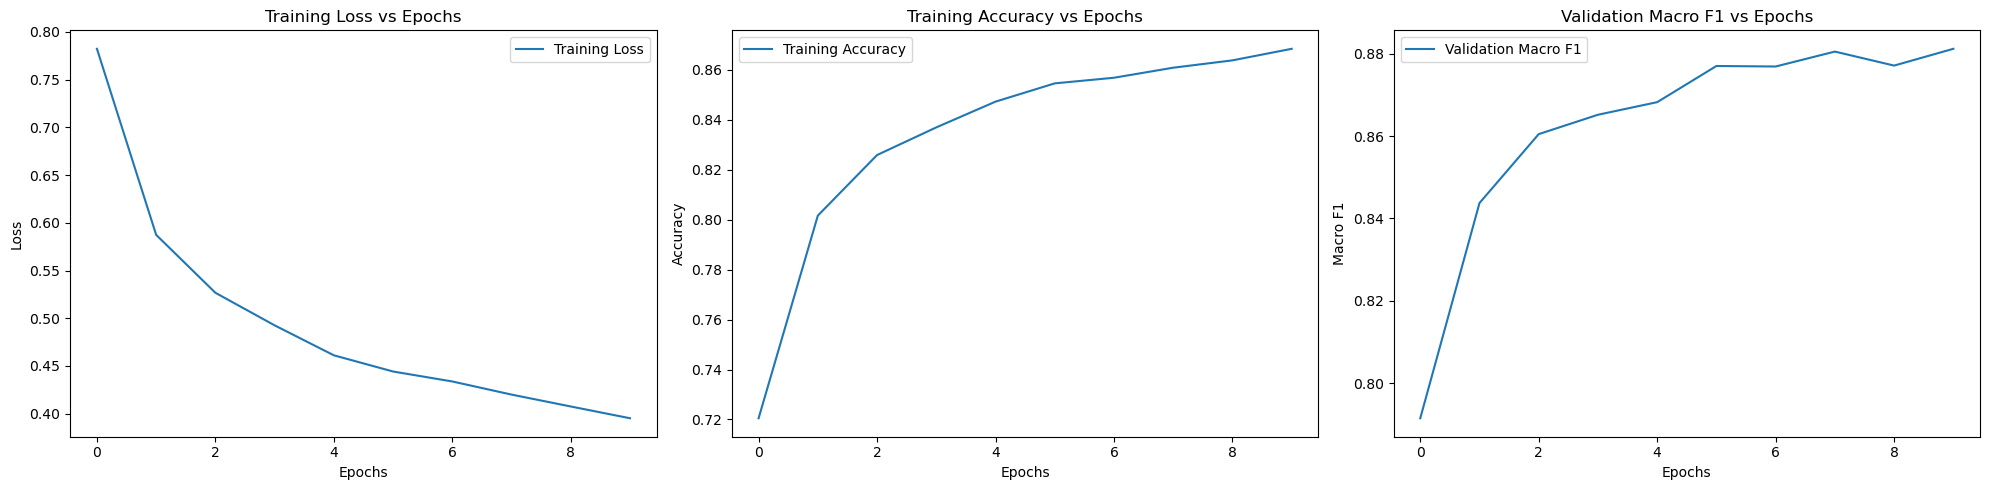

Training "large2" model with learning rate: 0.004
Epoch     Train Loss     Train Accuracy      Validation Loss     Validation Accuracy      Validation Macro-F1      
1 / 10    0.4367         0.8585              0.3369              0.8791                   0.8776                   
2 / 10    0.3951         0.8692              0.3277              0.8821                   0.8809                   
3 / 10    0.3716         0.8764              0.3172              0.8868                   0.8860                   
4 / 10    0.3579         0.8817              0.3172              0.8885                   0.8878                   
5 / 10    0.3514         0.8840              0.3216              0.8863                   0.8860                   
6 / 10    0.3403         0.8868              0.3115              0.8893                   0.8891                   
7 / 10    0.3354         0.8879              0.3174              0.8912                   0.8913                   
8 / 10    0.3306      

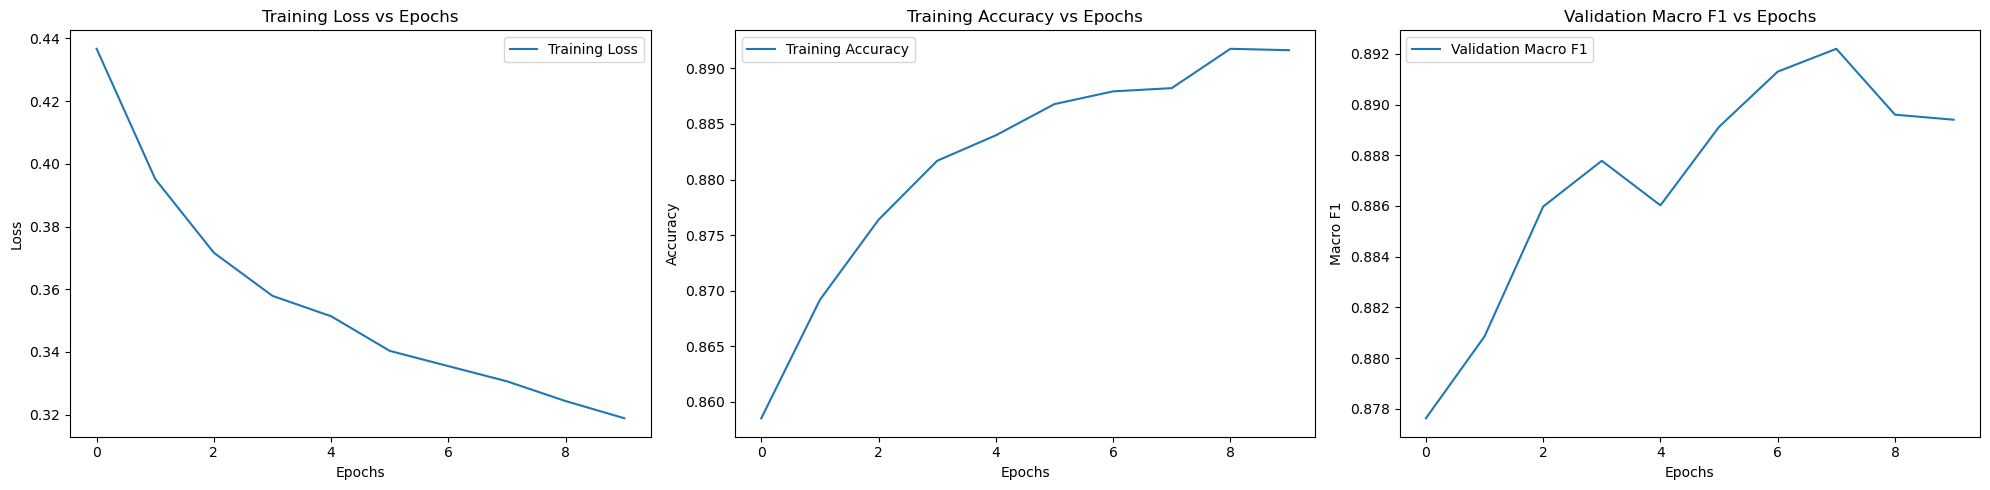

Training "large2" model with learning rate: 0.003
Epoch     Train Loss     Train Accuracy      Validation Loss     Validation Accuracy      Validation Macro-F1      
1 / 10    0.3376         0.8859              0.3178              0.8889                   0.8886                   
2 / 10    0.3169         0.8940              0.3137              0.8902                   0.8902                   
3 / 10    0.3025         0.8983              0.3099              0.8932                   0.8931                   
4 / 10    0.2907         0.9032              0.3081              0.8933                   0.8933                   
5 / 10    0.2896         0.9034              0.3071              0.8952                   0.8951                   
6 / 10    0.2810         0.9042              0.3118              0.8966                   0.8969                   
7 / 10    0.2771         0.9068              0.3132              0.8948                   0.8951                   
8 / 10    0.2709      

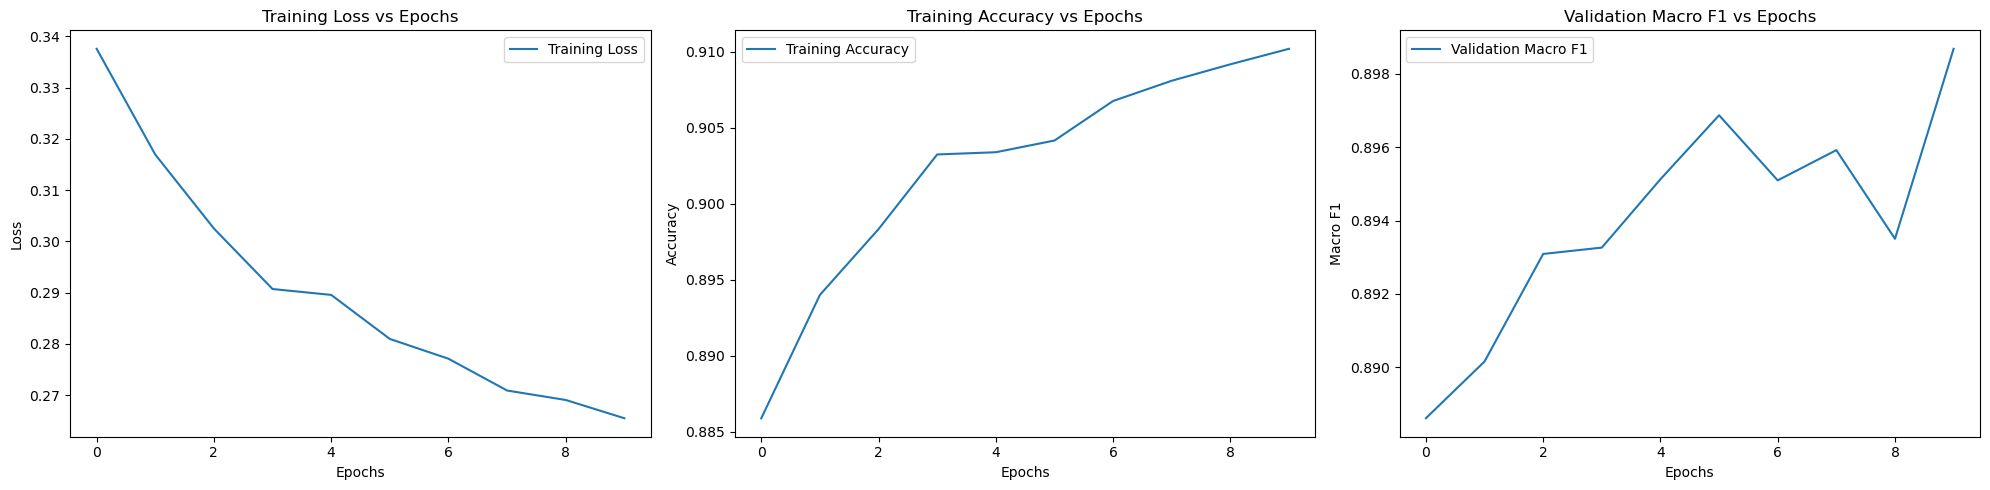

Training "large2" model with learning rate: 0.001
Epoch     Train Loss     Train Accuracy      Validation Loss     Validation Accuracy      Validation Macro-F1      
1 / 10    0.2489         0.9168              0.3160              0.8976                   0.8979                   
2 / 10    0.2347         0.9189              0.3130              0.8991                   0.8997                   
3 / 10    0.2309         0.9215              0.3143              0.8978                   0.8987                   
4 / 10    0.2283         0.9229              0.3101              0.8993                   0.8999                   
5 / 10    0.2241         0.9230              0.3166              0.8992                   0.9000                   
6 / 10    0.2199         0.9258              0.3152              0.8997                   0.9004                   
7 / 10    0.2220         0.9252              0.3139              0.8997                   0.9005                   
8 / 10    0.2147      

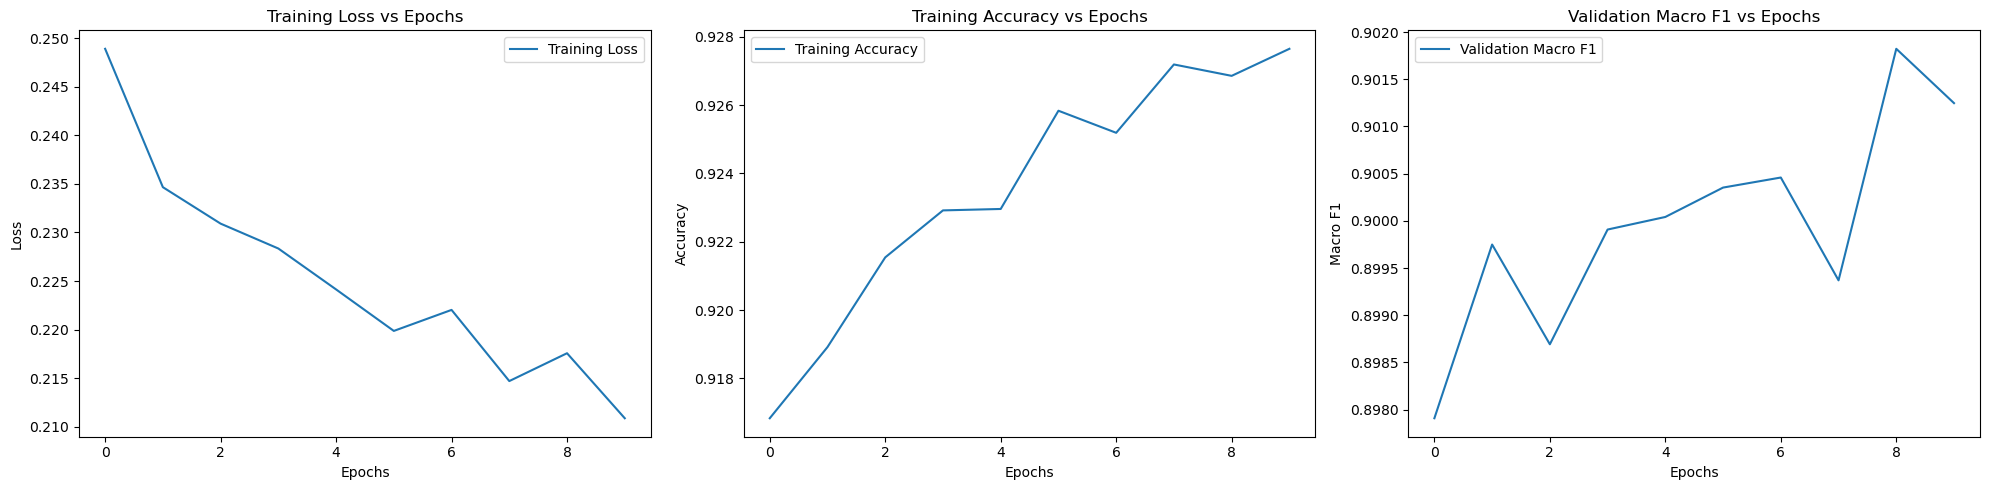

In [ ]:
best_model = None
# For each of the model architectures, train the model with different learning rates
for architecture in architectures:
    for learning_rate in learning_rates:
        print(f"Training \"{architecture}\" model with learning rate: {learning_rate}")
        
        model = NeuralNetwork(getPreferredArchitecture(architecture))
        val_macro_f1 = model.train(df_train, epochs=10, batch_size=100, learning_rate=learning_rate)
        
        if best_model is None or val_macro_f1 > best_model[1]:
            best_model = (model, val_macro_f1, architecture, learning_rate)

        model.save_weights(f'{weights_dir}/{architecture}_weights_{learning_rate}.pkl')

best_model[0].save_weights(f'{weights_dir}/best_model_{best_model[2]}_{best_model[3]}.pkl')

# model = NeuralNetwork(preferred_architecture)
# model.train(df_train, epochs=10, batch_size=100, learning_rate=0.005)
# model.save_weights(f'{architecture}_weights.pkl')

# Model Testing
---

In [12]:
label_map = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

def plot_confusion_matrix(data):
    plt.figure(figsize=(10, 7))
    sns.heatmap(data, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.values(), yticklabels=label_map.values())
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

X_test = df_test.drop(columns=['label']).values
y_test = df_test['label'].values

### Report: Confusion Matrix, Performance Metrics for each model

Architecture   Learning Rate  Test Accuracy       
small          0.005          0.8873              


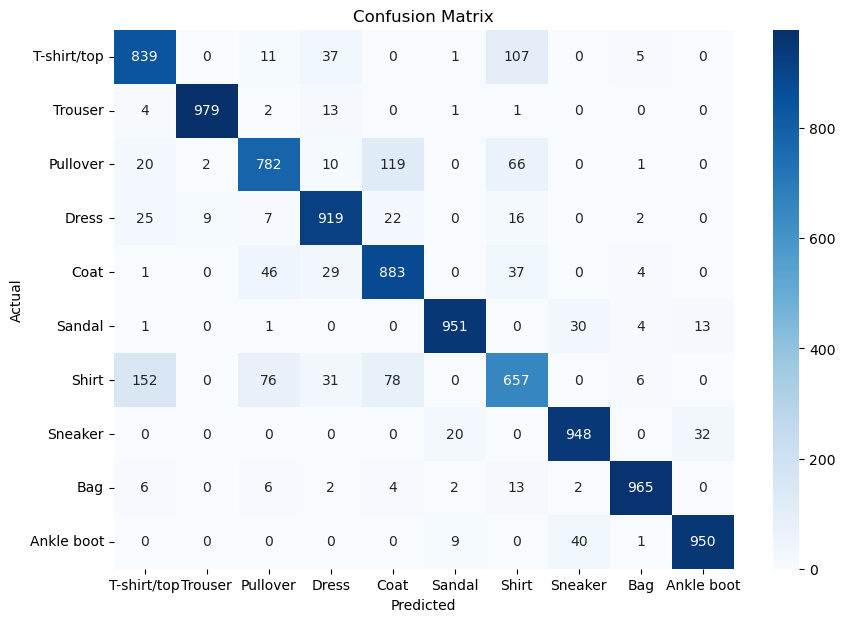

Architecture   Learning Rate  Test Accuracy       
small          0.004          0.8909              


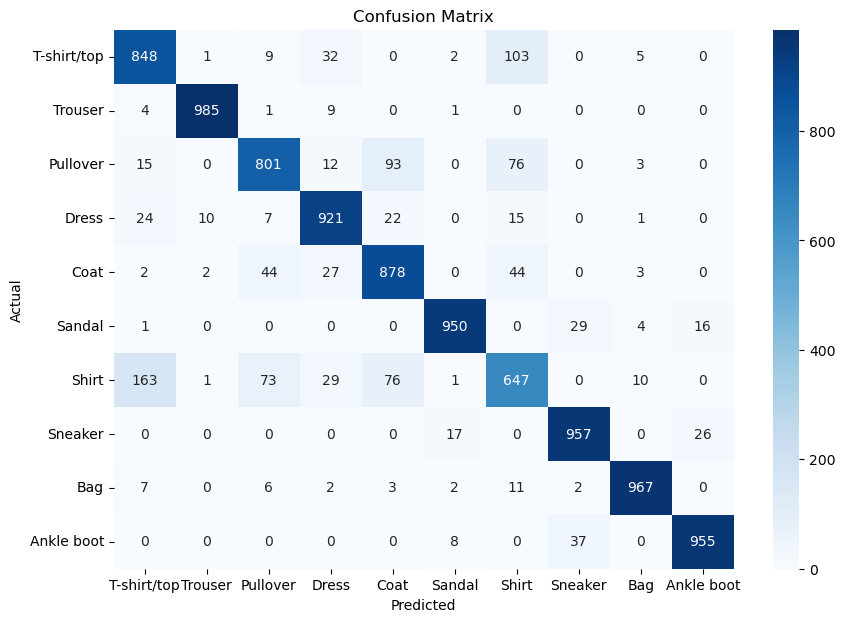

Architecture   Learning Rate  Test Accuracy       
small          0.003          0.8889              


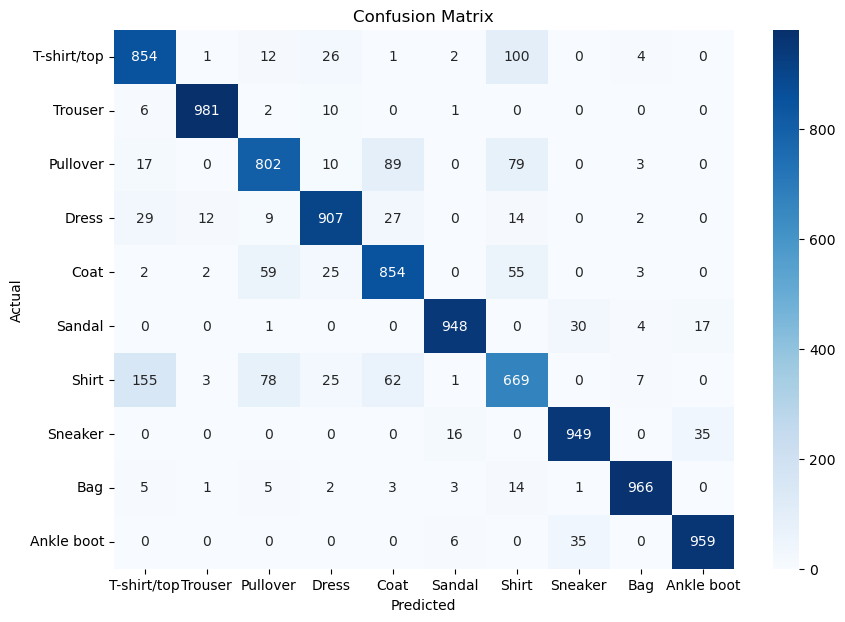

Architecture   Learning Rate  Test Accuracy       
small          0.001          0.8908              


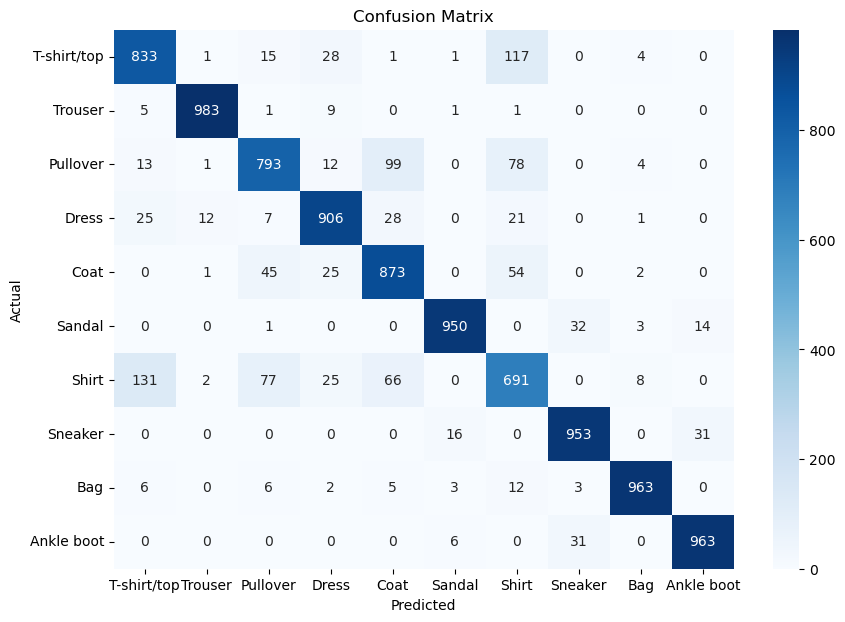

Architecture   Learning Rate  Test Accuracy       
large1         0.005          0.9018              


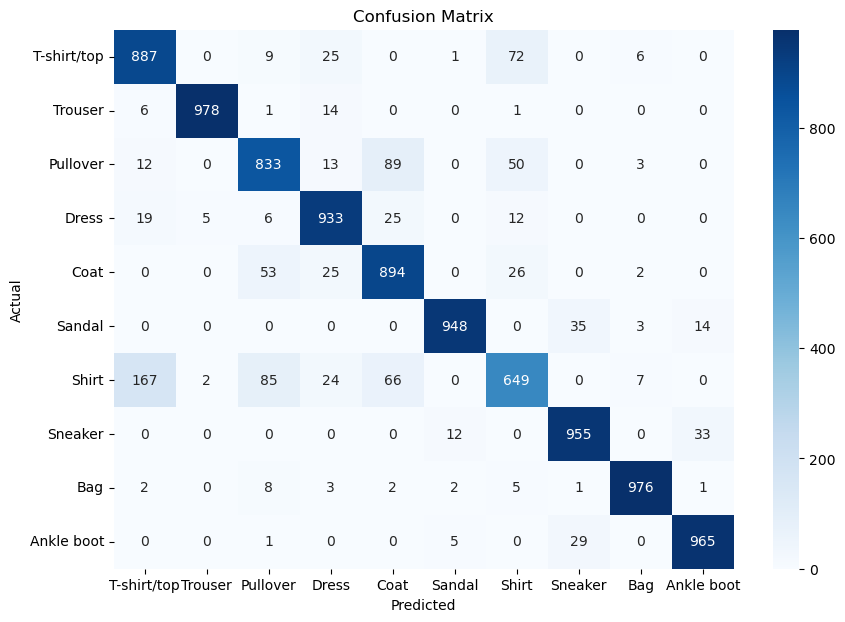

Architecture   Learning Rate  Test Accuracy       
large1         0.004          0.9041              


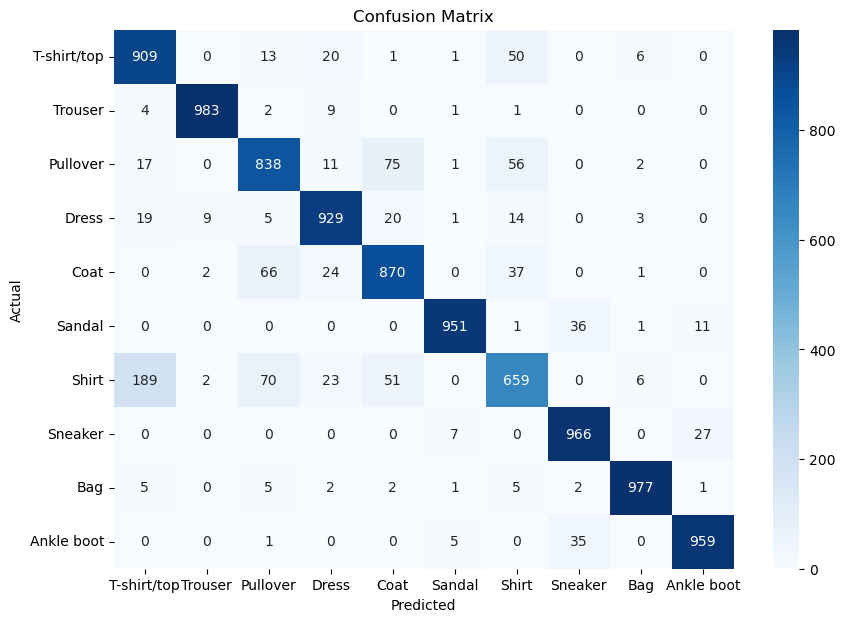

Architecture   Learning Rate  Test Accuracy       
large1         0.003          0.9045              


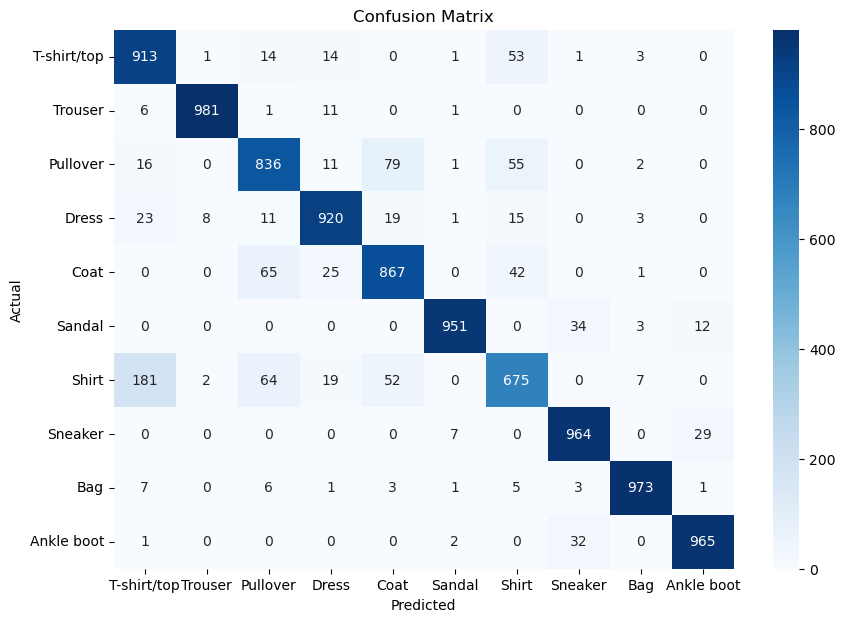

Architecture   Learning Rate  Test Accuracy       
large1         0.001          0.9084              


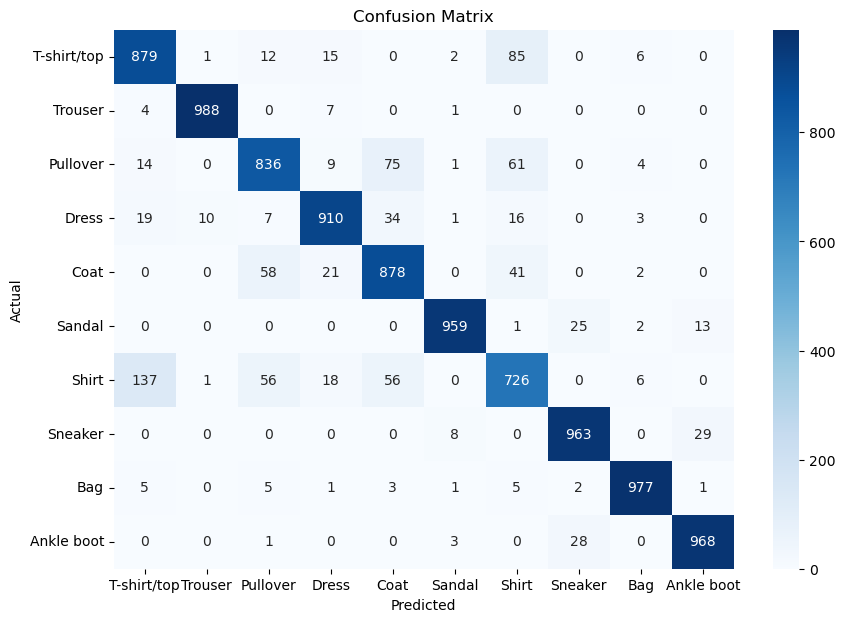

Architecture   Learning Rate  Test Accuracy       
large2         0.005          0.8866              


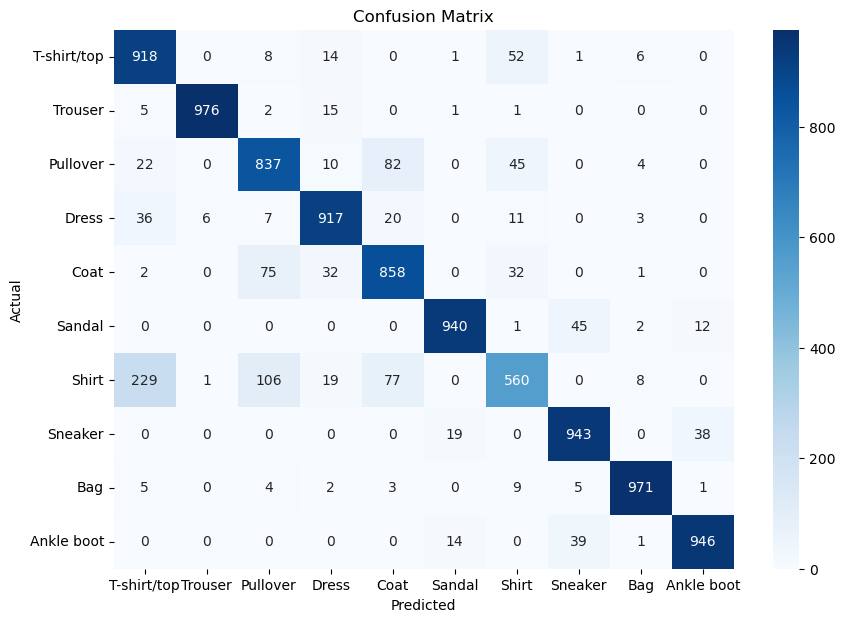

Architecture   Learning Rate  Test Accuracy       
large2         0.004          0.8948              


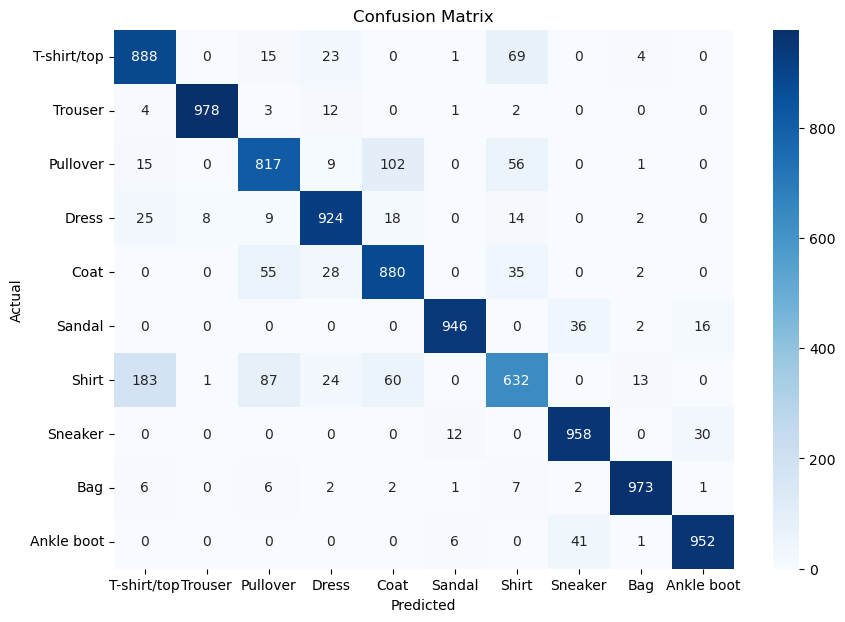

Architecture   Learning Rate  Test Accuracy       
large2         0.003          0.9023              


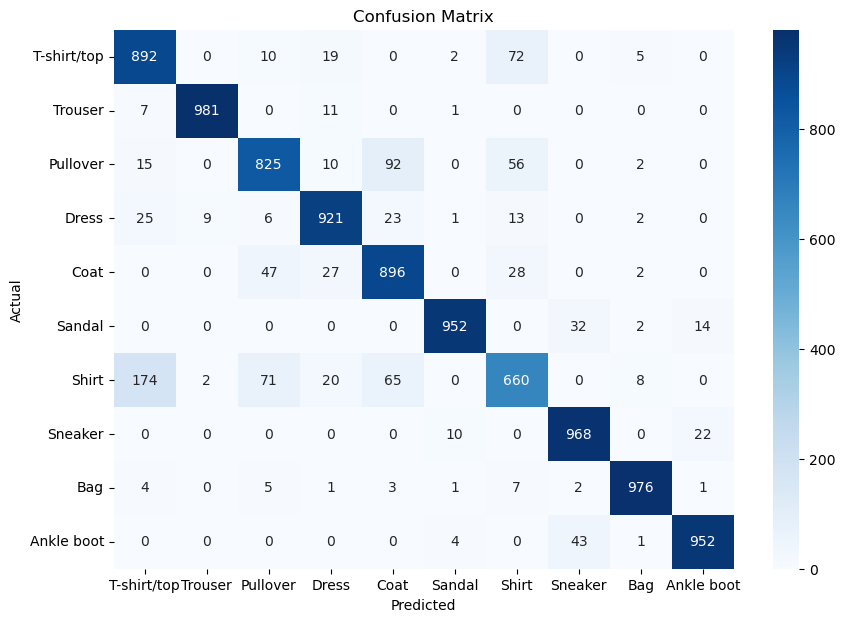

Architecture   Learning Rate  Test Accuracy       
large2         0.001          0.9039              


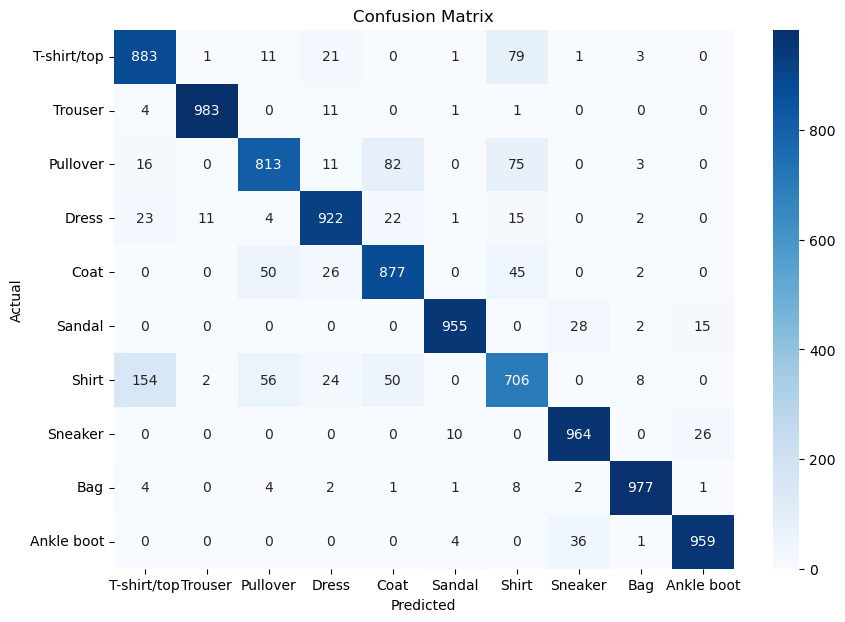

In [14]:
for architecture in architectures:
    for learning_rate in learning_rates:
        model = NeuralNetwork(getPreferredArchitecture(architecture))
        model.load_weights(f'{weights_dir}/{architecture}_weights_{learning_rate}.pkl')

        y_test_pred = model.forward(X_test, training=False)
        predicted_labels = np.argmax(y_test_pred, axis=1)

        accuracy = accuracy_score(y_test, predicted_labels)
        print(f"{'Architecture':<15}{'Learning Rate':<15}{'Test Accuracy':<20}")
        print(f"{architecture:<15}{learning_rate:<15}{accuracy:<20.4f}")
        
        cm = confusion_matrix(y_test, predicted_labels)
        plot_confusion_matrix(cm)


### Report: Best Model

In [13]:
X_test = (X_test + 1) * 127.5

/home/apurbo/miniconda3/envs/ml/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Architecture   Learning Rate  Test Accuracy       Precision           Recall              F1 Score            
large1         0.001          0.7862              0.3775              0.3111              0.3402              


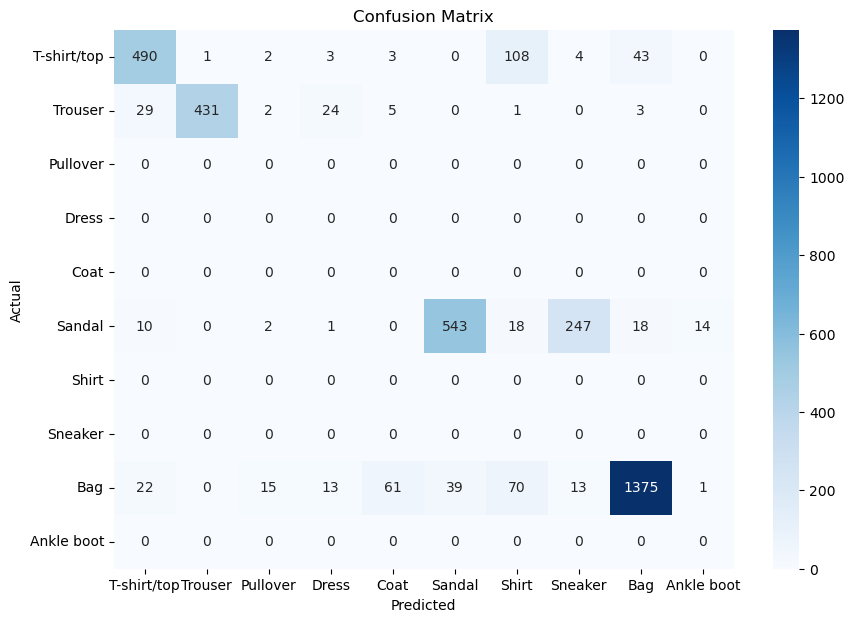

In [14]:

# Report the test metrics for the best model
# Get the preferred architecture and learning rate for the best model from it's filename
files = os.listdir(weights_dir)
best_model = None
for file in files:
    if file.startswith('best_model') or file.startswith('model'): # best_model_large1_0.001.pkl or model_1905096.pkl
        if file.startswith('model'):
            arch, lr = 'large1', 0.001 # Submission version -> Found by best f1 score
        else:
            arch, lr = file.split('_')[2:]
            lr = float(lr[:-4]) # -4 to remove the '.pkl' extension

        model = NeuralNetwork(getPreferredArchitecture(arch))
        model.load_weights(f'{weights_dir}/{file}')

        y_test_pred = model.forward(X_test, training=False)
        predicted_labels = np.argmax(y_test_pred, axis=1)

        accuracy = accuracy_score(y_test, predicted_labels)
        precision = precision_score(y_test, predicted_labels, average='macro')
        recall = recall_score(y_test, predicted_labels, average='macro')
        f1 = f1_score(y_test, predicted_labels, average='macro')
        print(f"{'Architecture':<15}{'Learning Rate':<15}{'Test Accuracy':<20}{'Precision':<20}{'Recall':<20}{'F1 Score':<20}")
        print(f"{arch:<15}{lr:<15}{accuracy:<20.4f}{precision:<20.4f}{recall:<20.4f}{f1:<20.4f}")

        cm = confusion_matrix(y_test, predicted_labels)
        plot_confusion_matrix(cm)
        break